<a href="https://colab.research.google.com/github/tejal1210/Pneumonia-Detection/blob/main/pneumonia_detection_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications import ResNet50, ResNet152V2, DenseNet121
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [3]:
!pip install imutils

In [4]:
from imutils import paths
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from tensorflow.keras.preprocessing import image

## Creating the Data Directory and Dataset

In [ ]:
# !pip install kaggle
# from google.colab import files
# files.upload() # upload kaggle.json file
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray
# !unzip pediatric-pneumonia-chest-xray.zip

In [17]:
train_path = 'Pediatric Chest X-ray Pneumonia/train'
test_path = 'Pediatric Chest X-ray Pneumonia/test'

In [18]:
normal_images = [img for img in os.listdir(f'{train_path}/NORMAL')]
pneumonia_images = [img for img in os.listdir(f'{train_path}/PNEUMONIA')]

In [19]:
#Randomly select few images from the set to view (say, 5 images)
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

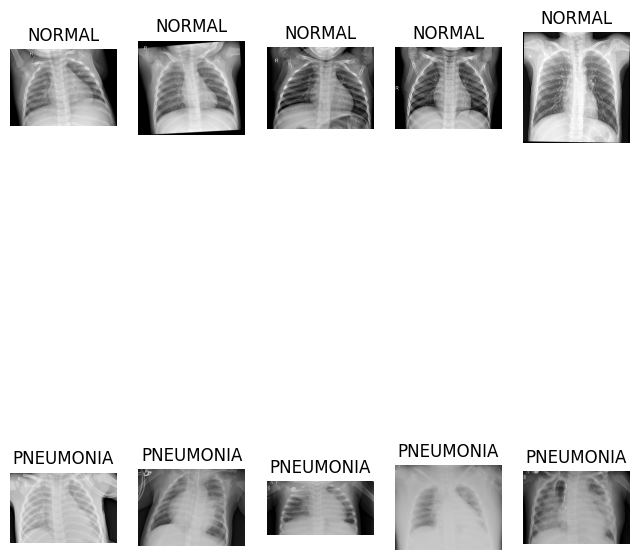

In [20]:
#Plot the selected images
from tensorflow.keras.preprocessing import image

fig = plt.figure(figsize=(8,10))
for i in range(10):
    if i<5:
        fpath = f'{train_path}/NORMAL/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_path}/PNEUMONIA/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2,5,i+1)

    im = image.load_img(fpath)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()

In [21]:
# #Generate an average image for each class from the the above classes of images
# #This will help understand the general characteristics of each class

# def img_to_matrix(fpath, flist, size=(64,64)):
#     for fname in flist:
#         full_path = fpath+fname
#         current_image = image.load_img(full_path, target_size = size, color_mode = 'grayscale')

#         #convert image to 64 x 64 matrix
#         img_mat1 = image.img_to_array(current_image)
#         img_mat1 = [img_mat1.ravel()]
#         try:
#             # concatenate different images
#             full_mat = np.concatenate((full_mat, img_mat1))
#         except UnboundLocalError:
#             # if not assigned yet, assign one
#             full_mat = img_mat1
#     return full_mat

# normal_images1 = img_to_matrix(f'{train_path}/NORMAL/', normal_images)
# pneumonia_images1 = img_to_matrix(f'{train_path}/PNEUMONIA/', pneumonia_images)


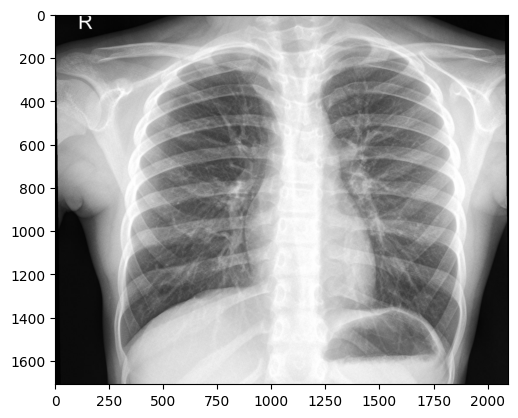

In [24]:
im = image.load_img("Pediatric Chest X-ray Pneumonia/test/NORMAL/IM-0036-0001.jpeg")
plt.imshow(im)

In [25]:
im.size

(2096, 1709)

In [26]:
# Fixed for our Pneumonia or not classes
NUM_CLASSES = 2
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
LEARNING_RATE = 1e-3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 53
STEPS_PER_EPOCH_VALIDATION = 11

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 8
BATCH_SIZE_VALIDATION = 8

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [27]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE_TRAINING,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=69
)
valid_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=69
)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE_TESTING,
    class_mode=None,
    shuffle=False,
    seed=69
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3)))
# construct the head of the model that will be placed on top of the
# the base model
model = Sequential()
model.add(baseModel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
for layer in baseModel.layers[:]:
    layer.trainable = False
print('conv_base is now NOT trainable')

29084464/29084464 [==============================] - 0s 0us/step
conv_base is now NOT trainable


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [30]:
# compile our model
print("Compiling the model...")
opt = Adam(lr=LEARNING_RATE, weight_decay=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])


Compiling the model...


In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [32]:
# train the head of the network
print("training the head...")

history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7947 - auc: 0.8238 - precision: 0.7754 - recall: 0.7661

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 113s 2s/step - loss: 0.7518 - accuracy: 0.7947 - auc: 0.8238 - precision: 0.7754 - recall: 0.7661 - val_loss: 0.5212 - val_accuracy: 0.7500 - val_auc: 0.8920 - val_precision: 0.7952 - val_recall: 0.7500
Epoch 2/10
53/53 [==============================] - 96s 2s/step - loss: 0.5898 - accuracy: 0.7948 - auc: 0.8621 - precision: 0.7864 - recall: 0.7901 - val_loss: 0.3683 - val_accuracy: 0.8977 - val_auc: 0.9665 - val_precision: 0.9070 - val_recall: 0.8864
Epoch 3/10
53/53 [==============================] - 105s 2s/step - loss: 0.4334 - accuracy: 0.8373 - auc: 0.9234 - precision: 0.8373 - recall: 0.8255 - val_loss: 0.3340 - val_accuracy: 0.8977 - val_auc: 0.9724 - val_precision: 0.9146 - val_recall: 0.8523
Epoch 4/10
53/53 [==============================] - 92s 2s/step - loss: 0.3506 - accuracy: 0.8821 - auc: 0.9526 - precision: 0.8750 - recall: 0.8585 - val_loss: 0.3107 - val_accuracy: 0.9091 - val_auc: 0.9719 - val_precision: 0.9101 - val_recall: 

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall'])


In [34]:
model.load_weights("../working/best.hdf5")

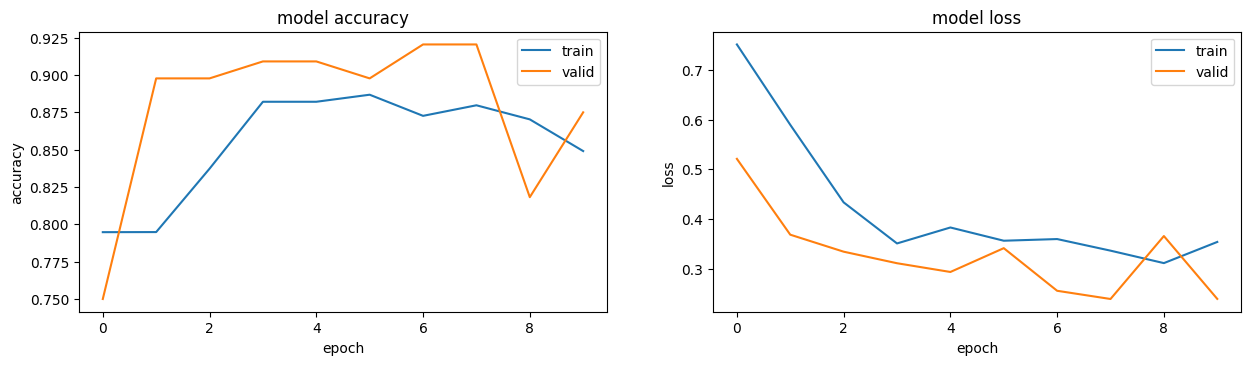

In [35]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [36]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict(test_generator, steps = len(test_generator), verbose = 2)

predicted_class_indices = np.argmax(pred, axis = 1)

624/624 - 108s - 108s/epoch - 173ms/step


In [37]:
TEST_DIR = 'Pediatric Chest X-ray Pneumonia/test/'
l = random.sample(range(0, len(test_generator.filenames)), 25)
print(l)

[41, 445, 131, 385, 85, 156, 69, 249, 291, 336, 440, 485, 330, 241, 348, 271, 374, 415, 227, 194, 279, 577, 582, 386, 402]


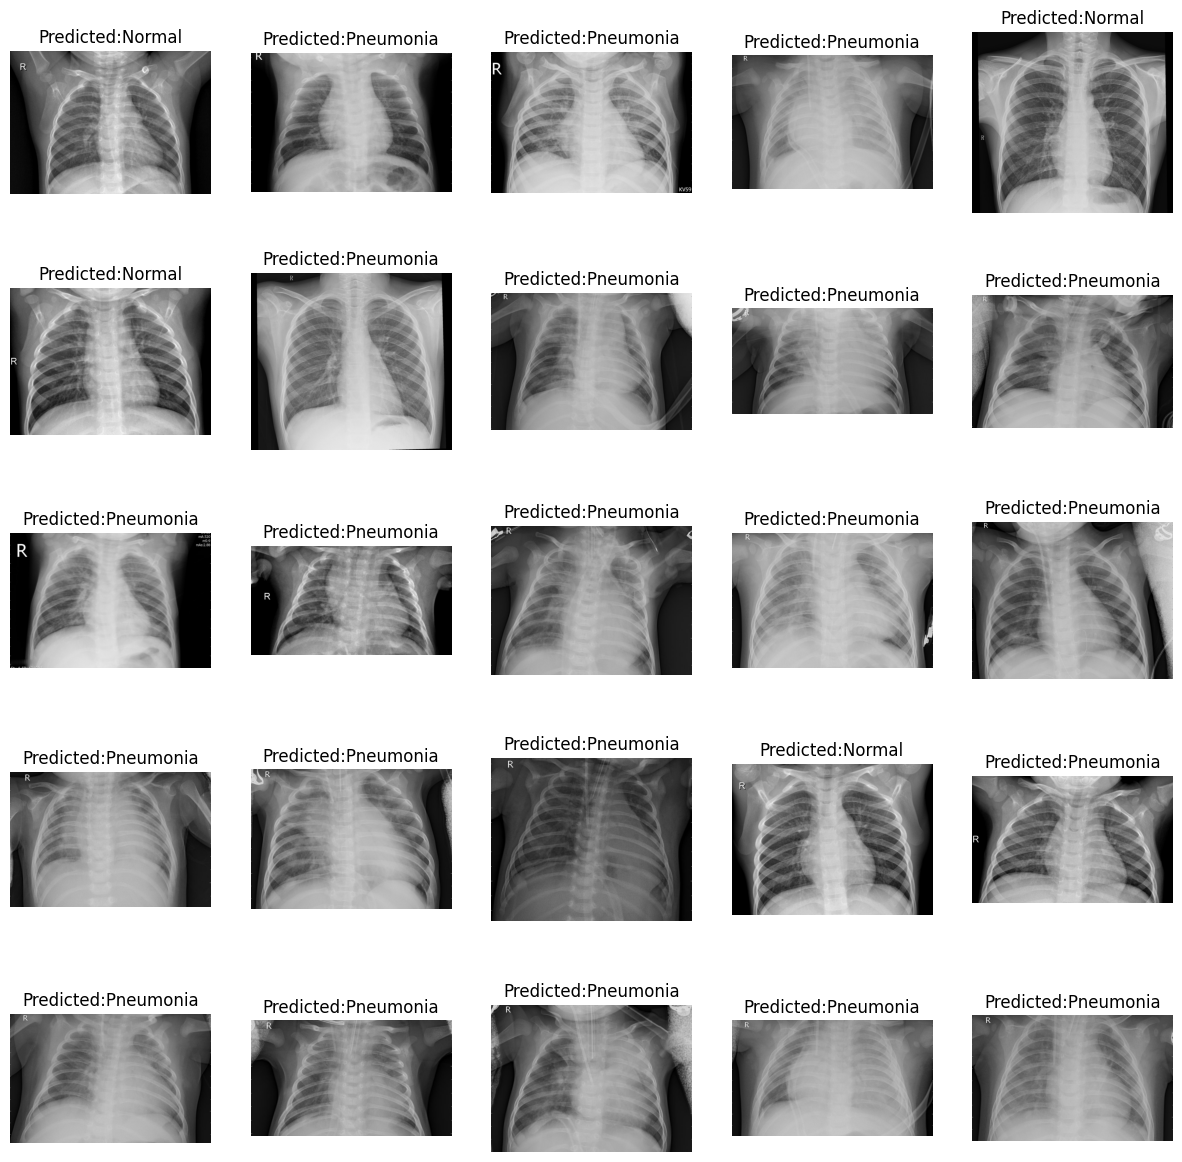

In [38]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    img = cv2.imread(TEST_DIR + test_generator.filenames[l[i]])


    # a if condition else b
    predicted_class = "Pneumonia" if predicted_class_indices[l[i]] else "Normal"

    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))

plt.show()

In [39]:
for i in range(0,25):
    print(test_generator.filenames[l[i]], predicted_class_indices[l[i]])

NORMAL/IM-0067-0001.jpeg 0
PNEUMONIA/person1653_virus_2859.jpeg 1
NORMAL/NORMAL2-IM-0222-0001.jpeg 1
PNEUMONIA/person152_bacteria_721.jpeg 1
NORMAL/NORMAL2-IM-0059-0001.jpeg 0
NORMAL/NORMAL2-IM-0280-0001.jpeg 0
NORMAL/NORMAL2-IM-0007-0001.jpeg 1
PNEUMONIA/person104_bacteria_491.jpeg 1
PNEUMONIA/person120_bacteria_571.jpeg 1
PNEUMONIA/person134_bacteria_642.jpeg 1
PNEUMONIA/person1649_virus_2850.jpeg 1
PNEUMONIA/person18_virus_49.jpeg 1
PNEUMONIA/person133_bacteria_634.jpeg 1
PNEUMONIA/person101_bacteria_483.jpeg 1
PNEUMONIA/person138_bacteria_658.jpeg 1
PNEUMONIA/person112_bacteria_538.jpeg 1
PNEUMONIA/person147_bacteria_705.jpeg 1
PNEUMONIA/person161_bacteria_757.jpeg 1
NORMAL/NORMAL2-IM-0374-0001-0001.jpeg 0
NORMAL/NORMAL2-IM-0331-0001.jpeg 1
PNEUMONIA/person114_bacteria_546.jpeg 1
PNEUMONIA/person82_bacteria_402.jpeg 1
PNEUMONIA/person83_bacteria_409.jpeg 1
PNEUMONIA/person152_bacteria_722.jpeg 1
PNEUMONIA/person159_bacteria_746.jpeg 1


In [40]:
def Targetization(folder_path, target_path):
    label = []
    for path, tag in target_path:
        for filename in os.listdir(folder_path + path):
            img = cv2.imread(os.path.join(folder_path, path, filename)) # second param: 0 is b&w picture
            if img is not None:
                label.append(tag)
    return np.array(label)

base_dir= "Pediatric Chest X-ray Pneumonia/"
y_test = Targetization(base_dir, target_path=[("test/NORMAL/", 0,), ("test/PNEUMONIA/", 1,)])

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.8173076923076923
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       234
           1       0.79      0.96      0.87       390

    accuracy                           0.82       624
   macro avg       0.84      0.77      0.79       624
weighted avg       0.83      0.82      0.81       624



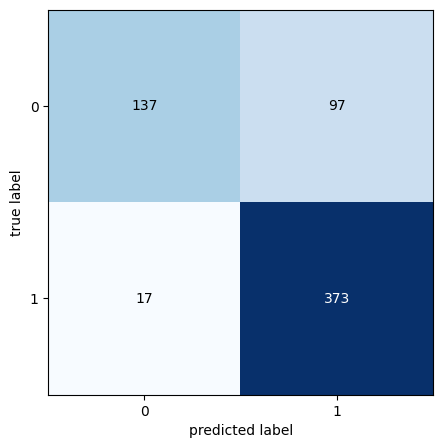

In [41]:
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(classification_report(y_test, predicted_class_indices))
plt.show()